## Decision Tree
Using the Titanic data.
1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [75]:
import pandas as pd
import acquire
import prepare

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [76]:
df = acquire.get_titanic_data()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [77]:
# Reduce obvious noise
df = df.set_index("passenger_id")
df = df.drop(columns=["class", "embarked"])

In [78]:
# What about nulls?
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
deck           688
embark_town      2
alone            0
dtype: int64

In [79]:
# Drop deck because there are far too many nulls
df = df.drop(columns=["deck"])

In [80]:
# Let's fill embark_town with the most common observation
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())

In [81]:
# Let's investigate the observations with missing age
# My first thought was empty age values might indicate children
# Looks like most of these individuals were traveling alone
no_age_info = df[df.age.isna()]
no_age_info.alone.value_counts()

1    133
0     44
Name: alone, dtype: int64

In [8]:
# Let's see how similar this group is to the population
for column in df.drop(columns=["age", "fare"]).columns:
    print(column)
    print("Population:")
    print(df[column].value_counts(normalize=True))
    print("No age")
    print(no_age_info[column].value_counts(normalize=True))
    print()
    print()

survived
Population:
0    0.616162
1    0.383838
Name: survived, dtype: float64
No age
0    0.706215
1    0.293785
Name: survived, dtype: float64


pclass
Population:
3    0.551066
1    0.242424
2    0.206510
Name: pclass, dtype: float64
No age
3    0.768362
1    0.169492
2    0.062147
Name: pclass, dtype: float64


sex
Population:
male      0.647587
female    0.352413
Name: sex, dtype: float64
No age
male      0.700565
female    0.299435
Name: sex, dtype: float64


sibsp
Population:
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: sibsp, dtype: float64
No age
0    0.774011
1    0.146893
8    0.039548
3    0.022599
2    0.016949
Name: sibsp, dtype: float64


parch
Population:
0    0.760943
1    0.132435
2    0.089787
3    0.005612
5    0.005612
4    0.004489
6    0.001122
Name: parch, dtype: float64
No age
0    0.887006
2    0.067797
1    0.045198
Name: parch, dtype: float64


embark_town
Population:
Southampton    0.724409
Cherbou

In [83]:
# Looking at the distribution of values, it appears that no age subgroup is very close to the population
# If we needed to be more certain, we could perform hypothesis testing
# It looks like there's nothing wildly different about the no age group compared to the population
# So we'll impute using the median age
df.age = df.age.fillna(value=df.age.median())

### Encoding reminder:
Southampton, Queenstown, and Cherbourg were the embark towns
If embark_town_Queenstown and embark_town_Southampton are both 0, then Cherbourg it is!

In [84]:
# Time to encode the encodeable!
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns we encoded
df = df.drop(columns=["sex", "embark_town"])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)
df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


In [85]:
# Time to split!
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [86]:
X_train, y_train = train.drop(columns='survived'), train.survived
X_validate, y_validate = validate.drop(columns='survived'), validate.survived
X_test, y_test = test.drop(columns='survived'), test.survived

In [87]:
train.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
583,0,1,36.0,0,0,40.1250,1,1,0,0
165,1,3,9.0,0,2,20.5250,0,1,0,1
50,0,3,7.0,4,1,39.6875,0,1,0,1
259,1,2,50.0,0,1,26.0000,0,0,0,1
306,1,1,28.0,0,0,110.8833,1,0,0,0


## Onto Modeling 

In [14]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [15]:
# Make the model
tree1 = DecisionTreeClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
tree1 = tree1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.820433,0.760000,0.799197,0.790217,0.797255
recall,0.863192,0.696335,0.799197,0.779764,0.799197
f1-score,0.841270,0.726776,0.799197,0.784023,0.797358
support,307.000000,191.000000,0.799197,498.000000,498.000000


In [16]:
# Let's 
for i in range(2, 11):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()


Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.820433    0.760000  0.799197    0.790217      0.797255
recall       0.863192    0.696335  0.799197    0.779764      0.799197
f1-score     0.841270    0.726776  0.799197    0.784023      0.797358
support    307.000000  191.000000  0.799197  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.829341    0.817073  0.825301    0.823207      0.824636
recall       0.902280    0.701571  0.825301    0.801925      0.825301
f1-score     0.864275    0.754930  0.825301    0.809602      0.822337
support    307.000000  191.000000  0.825301  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.831858    0.842767  0.835341    0.837313      0.836042
recall       0.918567    0.701571  0.835341    0.810069      0.835341
f1-score     

## As we might expect
The more depth to the tree, the more the model fits to the training data
But we need to expect more to the story!
How well the model works on data it hasn't seen before?

In [17]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.799197,0.761682,0.037515
1,3,0.825301,0.799065,0.026236
2,4,0.835341,0.794393,0.040949
3,5,0.853414,0.799065,0.054348
4,6,0.865462,0.789720,0.075742
5,7,0.883534,0.780374,0.103160
6,8,0.899598,0.789720,0.109879
7,9,0.917671,0.799065,0.118605
8,10,0.937751,0.785047,0.152704
9,11,0.955823,0.813084,0.142739


In [50]:
# We can modify the above code to set a threshhold of difference
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
# And this will be a good example of a `break` statement in a loop

# Set our threshold for how overfit we'll tolerate
threshold = 0.10

models = []
metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)   
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    # Calculate the difference
    difference = in_sample_accuracy - out_of_sample_accuracy
    
    # Add a conditional to check vs. the threshold
    if difference > threshold:
        break
    
    # Formulate the output for each model's performance on train and validate
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        "difference": difference
    }
    
    # Add the metrics dictionary to the list, so we can make a dataframe
    metrics.append(output)
    
    # Add the specific tree to a list of trained models
    models.append(tree)
    
df = pd.DataFrame(metrics)
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.799197,0.761682,0.037515
1,3,0.825301,0.799065,0.026236
2,4,0.835341,0.794393,0.040949
3,5,0.853414,0.799065,0.054348
4,6,0.865462,0.789720,0.075742


In [46]:
models

[RandomForestClassifier(max_depth=2, random_state=123),
 RandomForestClassifier(max_depth=3, random_state=123),
 RandomForestClassifier(max_depth=4, random_state=123),
 RandomForestClassifier(max_depth=5, random_state=123),
 RandomForestClassifier(max_depth=6, random_state=123)]

In [51]:
accuracy = round(models.score(X_train, y_train), 2)
print(f'Training accuracy: {accuracy}')

AttributeError: 'list' object has no attribute 'score'

In [49]:
# TODO: view the accuracy on the validate split
models.score(X_validate, y_validate)

AttributeError: 'list' object has no attribute 'score'

In [53]:
models.predict(X_validate)

AttributeError: 'list' object has no attribute 'predict'

In [ ]:
# TODO: create a new column on the train dataframe that contains the models predictions
train['prediction'] = model.predict(X_train)
train.head()

In [88]:
pd.DataFrame(classification_report(train.survived, train.prediction, output_dict=True)).transpose()

AttributeError: 'DataFrame' object has no attribute 'prediction'

## Random Forest - 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [55]:
# Make the model
forest1 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state=123)

# Fit the model (on train and only train)
tree1 = forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.953416,1.000000,0.96988,0.976708,0.971283
recall,1.000000,0.921466,0.96988,0.960733,0.969880
f1-score,0.976153,0.959128,0.96988,0.967640,0.969623
support,307.000000,191.000000,0.96988,498.000000,498.000000


### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [56]:
# Let's 
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.815029    0.835526  0.821285    0.825278      0.822890
recall       0.918567    0.664921  0.821285    0.791744      0.821285
f1-score     0.863706    0.740525  0.821285    0.802115      0.816462
support    307.000000  191.000000  0.821285  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.836257    0.865385  0.845382    0.850821      0.847429
recall       0.931596    0.706806  0.845382    0.819201      0.845382
f1-score     0.881356    0.778098  0.845382    0.829727      0.841753
support    307.000000  191.000000  0.845382  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.842566    0.883871  0.855422    0.863218      0.858408
recall       0.941368    0.717277  0.855422    0.829323      0.855422
f1-score     

### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [58]:
# We can modify the above code to set a threshhold of difference
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
# And this will be a good example of a `break` statement in a loop

# Set our threshold for how overfit we'll tolerate
threshold = 0.10

models = []
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, min_samples_leaf=1, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)   
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    # Calculate the difference
    difference = in_sample_accuracy - out_of_sample_accuracy
    
    # Add a conditional to check vs. the threshold
    if difference > threshold:
        break
    
    # Formulate the output for each model's performance on train and validate
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        "difference": difference
    }
    
    # Add the metrics dictionary to the list, so we can make a dataframe
    metrics.append(output)
    
    # Add the specific tree to a list of trained models
    models.append(forest)
    
df = pd.DataFrame(metrics)
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.821285,0.771028,0.050257
1,3,0.845382,0.794393,0.050989
2,4,0.855422,0.799065,0.056356
3,5,0.865462,0.803738,0.061724
4,6,0.891566,0.813084,0.078482


### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth

In [59]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,18,0.925703,0.822430,0.103273
1,3,17,0.901606,0.817757,0.083849
2,4,16,0.887550,0.817757,0.069793
3,5,15,0.877510,0.780374,0.097136
4,6,14,0.871486,0.799065,0.072421
5,7,13,0.869478,0.789720,0.079758
6,8,12,0.865462,0.794393,0.071069
7,9,11,0.857430,0.794393,0.063037
8,10,10,0.857430,0.785047,0.072383
9,11,9,0.849398,0.785047,0.064351


<AxesSubplot:xlabel='max_depth', ylabel='difference'>

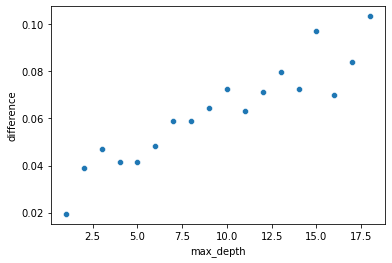

In [60]:
sns.scatterplot(x="max_depth", y="difference", data=df)

<AxesSubplot:xlabel='min_samples_per_leaf', ylabel='difference'>

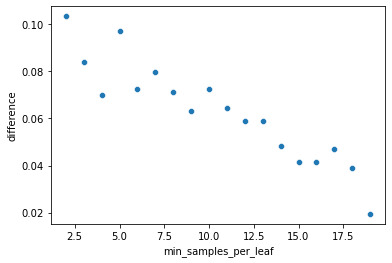

In [61]:
sns.scatterplot(x="min_samples_per_leaf", y="difference", data=df)

<AxesSubplot:xlabel='difference', ylabel='validate_accuracy'>

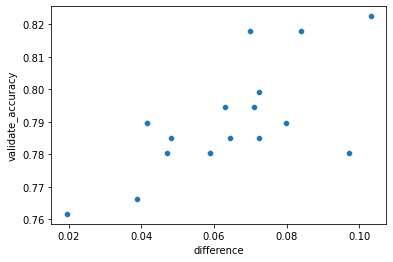

In [62]:
sns.scatterplot(x="difference", y="validate_accuracy", data=df)

### What if we increase both min_samples_per_leaf and max_depth 

In [63]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.821285,0.771028,0.050257
1,3,3,0.845382,0.785047,0.060335
2,4,4,0.847390,0.794393,0.052997
3,5,5,0.859438,0.799065,0.060372
4,6,6,0.861446,0.799065,0.062380
5,7,7,0.863454,0.789720,0.073734
6,8,8,0.863454,0.789720,0.073734
7,9,9,0.855422,0.794393,0.061029
8,10,10,0.857430,0.785047,0.072383
9,11,11,0.849398,0.785047,0.064351


### What about a fixed depth and increasing min_samples_leaf

In [64]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 50

for i in range(2, max_depth):
    # Make the model
    depth = 10
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,10,0.921687,0.822430,0.099257
1,3,10,0.899598,0.808411,0.091187
2,4,10,0.887550,0.813084,0.074466
3,5,10,0.877510,0.794393,0.083118
4,6,10,0.871486,0.799065,0.072421
5,7,10,0.869478,0.789720,0.079758
6,8,10,0.867470,0.794393,0.073077
7,9,10,0.857430,0.794393,0.063037
8,10,10,0.857430,0.785047,0.072383
9,11,10,0.849398,0.785047,0.064351


### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [70]:
# the deeper the depth the training data is better. 
models


[RandomForestClassifier(max_depth=2, random_state=123),
 RandomForestClassifier(max_depth=3, random_state=123),
 RandomForestClassifier(max_depth=4, random_state=123),
 RandomForestClassifier(max_depth=5, random_state=123),
 RandomForestClassifier(max_depth=6, random_state=123)]

In [72]:
forest.feature_importances_

array([0.2038634 , 0.01708661, 0.00133926, 0.00934207, 0.16349955,
       0.05107084, 0.53715195, 0.        , 0.01664632])

In [73]:
X_train.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'alone', 'sex_male',
       'embark_town_Queenstown', 'embark_town_Southampton'],
      dtype='object')

# KNN

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample) 

In [ ]:
df = acquire.get_titanic_data()
df.head(2)

In [ ]:
df = df.set_index("passenger_id")
df = df.drop(columns=["class", "embarked"])
df = df.drop(columns=["deck"])
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())
# Time to encode the encodeable!
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns we encoded
df = df.drop(columns=["sex", "embark_town"])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)
df.head()

In [ ]:
df.isna().sum()

In [ ]:
df.age = df.age.fillna(value=df.age.median())

In [ ]:
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [ ]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
y_pred = knn.predict(X_train)
y_pred

In [ ]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba

## 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

## 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
report = classification_report(y_train, y_pred, output_dict=True)
print("KNN")
pd.DataFrame(report)

In [ ]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

## 4. Run through steps 2-4 setting k to 10

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)

In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
report = classification_report(y_train, y_pred, output_dict=True)
print("KNN")
pd.DataFrame(report)

In [ ]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

## 5. Run through setps 2-4 setting k to 20

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20, weights='uniform')

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)

In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
report = classification_report(y_train, y_pred, output_dict=True)
print("KNN")
pd.DataFrame(report)

In [ ]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

## 6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [ ]:
# because we changed the k setting. The k setting of 5 performs better, because we are keeping the distance closer.

## 7. Which model performs best on our out-of-sample data from validate?

In [ ]:
# the k setting of 20 performs better on validate.

# Logistic Regression
Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = acquire.get_titanic_data()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [23]:
df = df.set_index("passenger_id")
df = df.drop(columns=["class", "embarked"])
df = df.drop(columns=["deck"])
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())
# Time to encode the encodeable!
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns we encoded
df = df.drop(columns=["sex", "embark_town"])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)

df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


In [24]:
df.age = df.age.fillna(value=df.age.median())

In [25]:
df.isna().sum()

survived                   0
pclass                     0
age                        0
sibsp                      0
parch                      0
fare                       0
alone                      0
sex_male                   0
embark_town_Queenstown     0
embark_town_Southampton    0
dtype: int64

In [26]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [27]:
train, validate, test = train_validate_test_split(df,
                                                  target = 'survived',
                                                  seed=123)

In [28]:
train.shape, validate.shape, test.shape

((498, 10), (214, 10), (179, 10))

In [29]:
train.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
583,0,1,36.0,0,0,40.1250,1,1,0,0
165,1,3,9.0,0,2,20.5250,0,1,0,1
50,0,3,7.0,4,1,39.6875,0,1,0,1
259,1,2,50.0,0,1,26.0000,0,0,0,1
306,1,1,28.0,0,0,110.8833,1,0,0,0


In [30]:
train.survived.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [38]:
baseline_accuracy = (train.survived == 0).mean()
round(baseline_accuracy, 3)

0.616

In [65]:
X_train, y_train = train.drop(columns='survived'), train.survived
X_validate, y_validate = validate.drop(columns='survived'), validate.survived
X_test, y_test = test.drop(columns='survived'), test.survived

In [66]:
train.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
583,0,1,36.0,0,0,40.1250,1,1,0,0
165,1,3,9.0,0,2,20.5250,0,1,0,1
50,0,3,7.0,4,1,39.6875,0,1,0,1
259,1,2,50.0,0,1,26.0000,0,0,0,1
306,1,1,28.0,0,0,110.8833,1,0,0,0


In [67]:
train.shape, validate.shape, test.shape

((498, 10), (214, 10), (179, 10))